In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
'''
Helper Functions
'''
def bin_values(array, N):
    # takes a 1D series of vals and returns a list of series
    bins = np.linspace(0, 1, N, endpoint=False)
    rv = []
    
    for i, bin in enumerate(bins):
        vals = array[np.digitize(array,bins)==i]
        vals.name = str(bin)
        rv.append(vals)

    return rv

def tag_bin(array, N):
    # takes a 1D series of vals and returns what bin they should be in
    bins = np.linspace(0, 1, N, endpoint=False)
    col = array.name
    df = pd.concat([array, pd.Series([0],name="bin")], axis=1)
    
    for i, bin in enumerate(bins):
        df.bin = np.digitize(df[col],bins)
        
    return df

In [3]:
%matplotlib inline
sns.set(style="darkgrid")

# Problem 1 - Analyzing 311 Data

In [4]:
files = ["311_Service_Requests_-_Graffiti_Removal.csv",
         "311_Service_Requests_-_Pot_Holes_Reported.csv",
         "311_Service_Requests_-_Sanitation_Code_Complaints.csv",
         "311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv"]

In [312]:
# Read data and massage the data
frames = [ pd.read_csv(file) for file in files ]
for frame in frames:
    frame.columns = map(str.lower, frame.columns)
df = pd.concat(frames)

# combine zip and zip code
df['zip code'].fillna(df['zip'], inplace=True)
del df['zip']

# drop other columns
df.drop(df.columns[[0,1,2,3,4,9,10,11,12,13,14,17]], axis=1, inplace=True)

# drop rows with NANs in essential columns
df.dropna(subset=["community area","zip code","ward","police district", "creation date", "completion date", "latitude"], inplace=True)

# combine status
df.replace("Pot Hole in Street","Pothole in Street", inplace=True)

# convert to categories
cat = df[["type of service request", "status", "what type of surface is the graffiti on?"]]
df[["type of service request", "status", "what type of surface is the graffiti on?"]] = cat.apply(lambda x: x.astype('category'))

# convert to integer
ints = df[["community area", "police district", "ward", "zip code"]]
df[["community area","police district", "ward", "zip code"]] = ints.apply(lambda x: x.astype('int'))

# convert to datetime
df['creation date'] = pd.to_datetime(df['creation date'],infer_datetime_format=True)
df['completion date'] = pd.to_datetime(df['completion date'],infer_datetime_format=True)
df['response time'] = df['completion date'] - df['creation date']

# combine with Chicago HHS data
hhs = pd.read_csv("Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
hhs.columns = map(str.lower, hhs.columns)
hhs.dropna(subset=["community area number"], inplace=True)
hhs[["community area number"]] = hhs[["community area number"]].apply(lambda x: x.astype('int'))

df = pd.merge(df, hhs, how='inner', left_on="community area", right_on="community area number")


df.columns

//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Index(['community area', 'completion date', 'creation date',
       'current activity', 'latitude', 'location', 'longitude',
       'most recent action', 'number of potholes filled on block',
       'police district', 'service request number', 'service request type',
       'ssa', 'status', 'street address', 'type of service request', 'ward',
       'what is the nature of this code violation?',
       'what type of surface is the graffiti on?',
       'where is the graffiti located?', 'x coordinate', 'y coordinate',
       'zip code', 'response time', 'community area number',
       'community area name', 'percent of housing crowded',
       'percent households below poverty', 'percent aged 16+ unemployed',
       'percent aged 25+ without high school diploma',
       'percent aged under 18 or over 64', 'per capita income ',
       'hardship index'],
      dtype='object')

In [313]:
# Taking a sample for speed
df = df.sample(1000)

df.head(4)

,community area,completion date,creation date,current activity,latitude,location,longitude,most recent action,number of potholes filled on block,police district,...,response time,community area number,community area name,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index
303632,22,2014-03-14,2014-02-16,NaN,41.916381,"(41.916381427045756, -87.66618973002115)",-87.666190,NaN,NaN,14,...,26 days,22,Logan Square,3.2,16.8,8.2,14.8,26.2,31908,23.0
803799,30,2015-10-01,2015-09-30,NaN,41.842553,"(41.84255285888442, -87.70849395547468)",-87.708494,NaN,NaN,10,...,1 days,30,South Lawndale,15.2,30.7,15.8,54.8,33.8,10402,96.0
140190,31,2013-01-14,2013-01-09,NaN,41.852057,"(41.852057210860515, -87.67633989257924)",-87.676340,NaN,NaN,10,...,5 days,31,Lower West Side,9.6,25.8,15.8,40.7,32.6,16444,76.0
632978,16,2011-03-31,2011-03-06,NaN,41.939170,"(41.93917009910052, -87.7297660002825)",-87.729766,NaN,NaN,17,...,25 days,16,Irving Park,6.3,13.1,10.0,22.4,31.6,27249,34.0


### Total Records

In [314]:
df.shape[0]

1000

### Null Values

In [315]:
nan = pd.Series(df.isnull().sum(axis=0).tolist(), index = df.columns)

## 311 Calls by police district

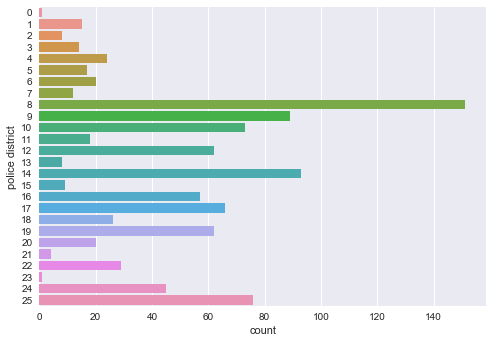

In [316]:
ax = sns.countplot(y="police district", data=df)

## 311 Calls by Type

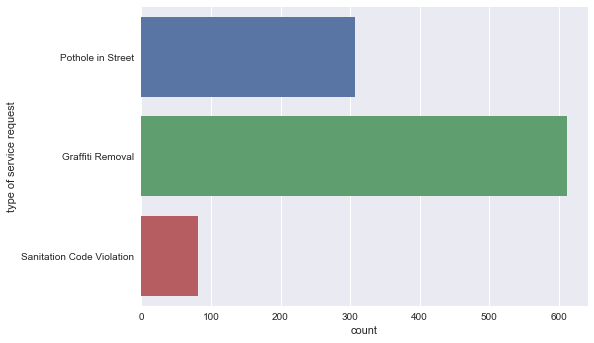

In [317]:
ax = sns.countplot(y="type of service request", data=df)

## Request Count by Community Area

In [318]:
df['community area name'].value_counts().head(10)

West Town          55
South Lawndale     54
Logan Square       53
Lower West Side    47
Belmont Cragin     36
Brighton Park      29
West Ridge         28
Irving Park        28
West Elsdon        27
Lake View          27
Name: community area name, dtype: int64

In [319]:
df['type of service request'].unique()

array(['Pothole in Street', 'Graffiti Removal', 'Sanitation Code Violation'], dtype=object)

In [320]:
indicators = df[['community area name','percent households below poverty', 'percent aged 16+ unemployed',
       'percent aged 25+ without high school diploma',
       'percent aged under 18 or over 64', 'per capita income ',
       'hardship index']].groupby('community area name').max()
indicators.join(df['community area name'].value_counts())

request_types = df['type of service request'].unique()

for request_type in request_types:
    t = df[df['type of service request'] == request_type]
    t = t['community area name'].value_counts()
    t = t.rename('num' + request_type)
    indicators = indicators.join(t)
    indicators[t.name].fillna(0, inplace=True)

In [321]:
indicators

,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index,numPothole in Street,numGraffiti Removal,numSanitation Code Violation
community area name,,,,,,,,,
Albany Park,19.2,10.0,32.9,32.0,21323,53.0,5.0,12.0,0.0
Archer Heights,14.1,16.5,35.9,39.2,16134,67.0,1.0,22.0,1.0
Armour Square,40.1,16.7,34.5,38.3,16148,82.0,0.0,4.0,0.0
Ashburn,10.4,11.7,17.7,36.9,23482,37.0,3.0,10.0,1.0
Auburn Gresham,27.6,28.3,18.5,41.9,15528,74.0,7.0,1.0,7.0
Austin,28.6,22.6,24.4,37.9,15957,73.0,11.0,6.0,0.0
Avalon Park,17.2,21.1,10.6,39.3,24454,41.0,3.0,0.0,2.0
Avondale,15.3,9.2,24.7,31.0,20039,42.0,2.0,22.0,0.0
Belmont Cragin,18.7,14.6,37.3,37.3,15461,70.0,9.0,24.0,3.0


### Graffiti locations

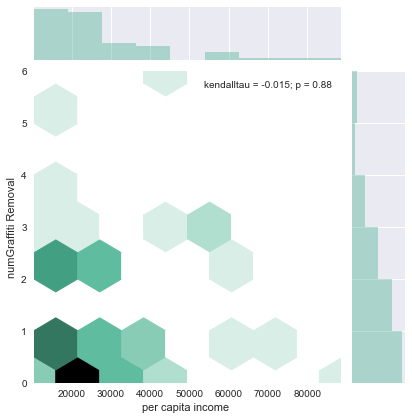

In [258]:
from scipy.stats import kendalltau
x = indicators['per capita income']
y = indicators['numGraffiti Removal']
ax = sns.jointplot(x, y, kind="hex", stat_func=kendalltau, color="#4CB391")

- We observe that the graffiti locations tend to be in areas that have a low per capita income

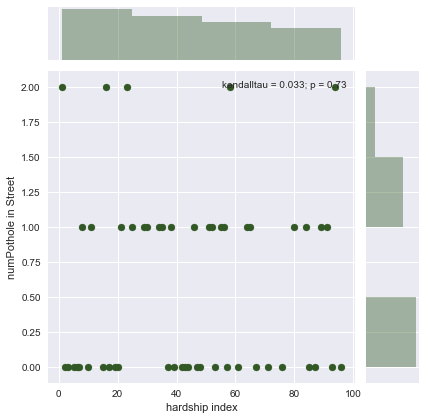

In [263]:
x = indicators['hardship index']
y = indicators['numPothole in Street']
ax = sns.jointplot(x, y, stat_func=kendalltau, color="#325925")

### Avg Response Time by Community Area

In [306]:
df[['community area name','response time']].mean()

Series([], dtype: float64)

### Types over time

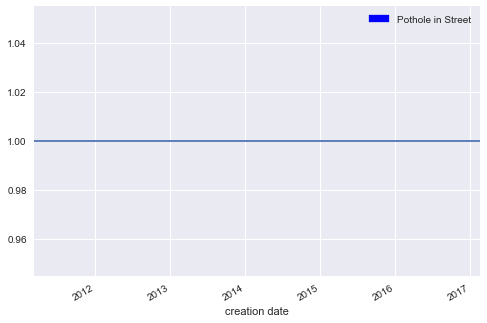

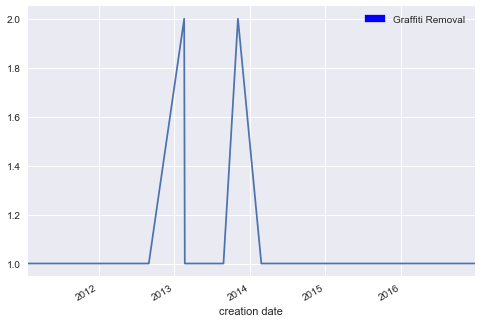

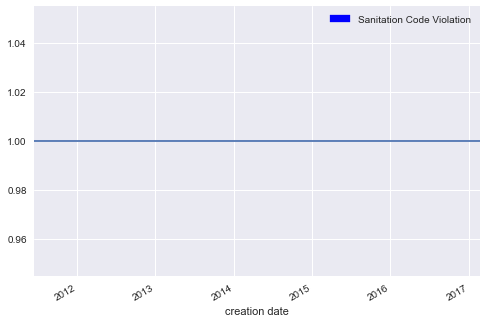

In [310]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
for t in df['type of service request'].unique():
    ax = df[df["type of service request"] == t][['creation date', "type of service request"]].groupby('creation date').count().plot()
    p = mpatches.Patch(color='blue', label=t)
    plt.legend(handles=[p])
plt.show()

### Type by Community Area

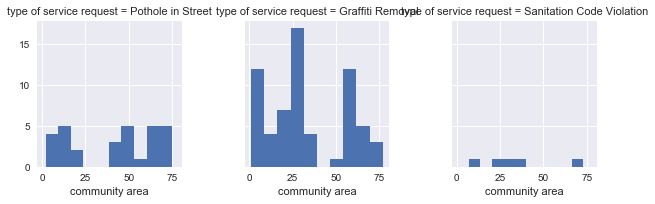

In [295]:
g = sns.FacetGrid(df, col="type of service request")
ax = g.map(plt.hist, "community area")

### Summary of findings

1) Graffiti is most frequent service request
2) Graffiti request tend to be in lower income areas
3) 
4)
5)

# Problem 2 - Data Augmentation with ACS

In [87]:
# storing
old = df

In [110]:
import requests
from requests.auth import HTTPBasicAuth

API_KEY = '9032d3c94c7f4afe905da54f889af02a6b51f63f'
request_url = "http://citysdk.commerce.gov"

variables = ['income','population','poverty','median_contract_rent','education_bachelors','poverty_family']

def acs_data (zip_code):
    request_obj = {
        'level': 'tract',
        'zip': int(zip_code),
        'sublevel': False,
        'api': 'acs5',
        'year': 2014,
        'variables': variables
        }

    data = None
    
    response = requests.post(request_url, auth=HTTPBasicAuth(API_KEY, None), json=request_obj)
    if response:
        data = response.json()
        data = data['features'][0]['properties']

    return data

In [111]:
# pull data by from zip code
codes = df[['zip code']]
codes = codes.drop_duplicates()

acs = codes.apply(acs_data, axis=1)
acs = acs.apply(pd.Series)

In [116]:
acs_ = acs
# humanize
columns = ['B01003_001E', 'B15003_022E', 'B17001_002E','B17012_002E', 'B19013_001E', 'B25058_001E']
ref = {"B15003_022E": "education_bachelors",
        "B19013_001E":   "income",
        "B25058_001E":   "median_contract_rent",
        "B01003_001E":   "population",
        "B17001_002E":   "poverty",
        "B17012_002E":   "poverty_family"}
new_name = [ref[key] for key in columns]
acs = acs[columns]
acs.columns = new_name
df[["community area","police district", "ward", "zip code"]] = ints.apply(lambda x: x.astype('int'))

In [118]:
# combine zip with acs
acs = pd.concat([acs,codes], axis=1)

In [154]:
# combine df with acs on zip
df = df.merge(acs, on='zip code')

### Rent and complaints

In [192]:
# build on indicators


#### What types of blocks get “Vacant and Abandoned Buildings Reported”?


#### What types of blocks get “Sanitation Code Complaints”?



#### Does that change over time in the data you collected?



#### What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Sanitation Code Complaints”?

# Problem 3